In [208]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [209]:
def rle_decode(mask_rle, shape=(1280, 1918, 1)):
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    img = img.reshape(shape)
    return img

Для обучения модели я использовала датасет Carvana Image Masking Challenge, в котором содержится 5088 фотографий машин.

In [210]:
df = pd.read_csv('data/train_masks.csv')
df.shape

(5088, 2)

Разделим выборку на тренировочную и валидационную. На тренировочной будем обучать нейросеть, на валидационной - предсказывать.

In [211]:
train_df = df[:4000]
val_df = df[4000:]

In [212]:
img_name, mask_rle = train_df.iloc[4]

img = cv2.imread('data/train/{}'.format(img_name))
mask = rle_decode(mask_rle)

Возьмем какую-нибудь картинку из датасета и применим к ней маску

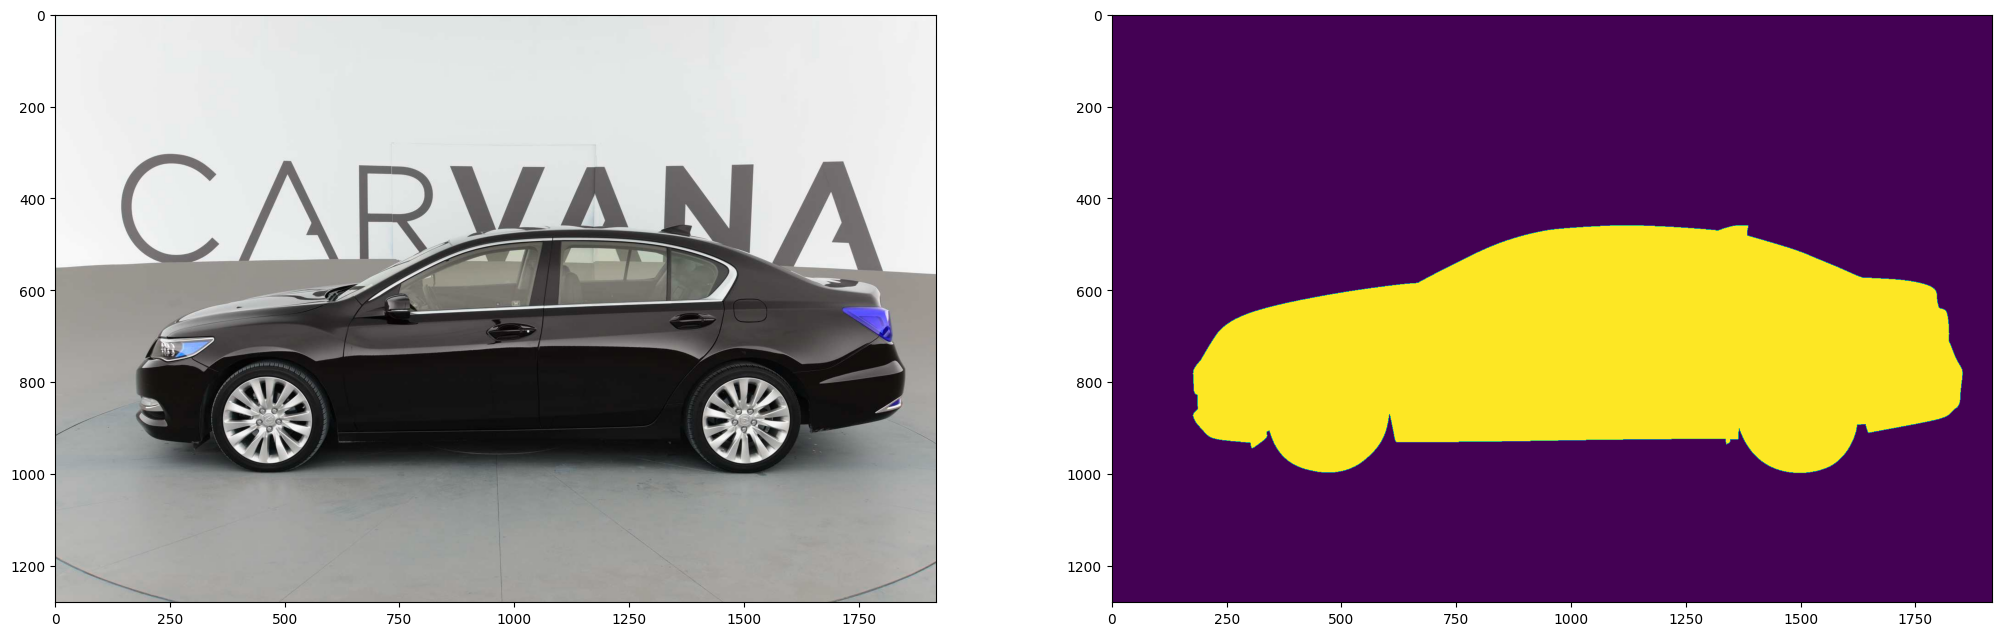

In [213]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(img)
axes[1].imshow(mask[..., 0])

plt.show()

Напишем генератор картинок из датасета, который будет формировать batch для нейронной сети

In [214]:
def keras_generator(gen_df, batch_size):
    while True:
        x_batch = []
        y_batch = []

        for i in range(batch_size):
            img_name, mask_rle = gen_df.sample(1).values[0]
            img = cv2.imread('data/train/{}'.format(img_name))
            mask = rle_decode(mask_rle)

            img = cv2.resize(img, (256, 256))
            mask = cv2.resize(mask, (256, 256))

            x_batch += [img]
            y_batch += [mask]
        
        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

In [215]:
for x, y in keras_generator(train_df, 16):
    break

In [216]:
x.shape

(16, 256, 256, 3)

x.shape должен быть 16, 256, 256, 3, где 16 - кол-во картинок, 256*256 - их размер, 3 - кол-во каналов

Unet

Unet — это архитектура свёрточной нейронной сети, предназначенная для сегментации изображений. Эта архитектура сети представляет собой последовательность слоёв свёртка + пулинг, которые сначала уменьшают пространственное разрешение картинки, а потом увеличивают его, предварительно объединив с данными картинки и пропустив через другие слои свёртки.

Отсутствие плотных слоев или полностью связанных слоев упрощает обучение и требует меньше вычислительных ресурсов. Архитектура состоит из 2 наборов сверточных слоев, работающих по принципу кодер-декодер. 1-й набор слоев вниз "сэмплирует" изображение, создавая набор изображений с разным разрешением. Второй набор слоев пытается воссоздать изображение в исходном разрешении, создавая набор изображений с увеличенной выборкой.
Во время downsampling-а сети могут обнаруживать наиболее важные особенности, не разрушая формы или текстуры объектов. Целью реконструкции является восполнение потерь, возникших на этапе кодирования.

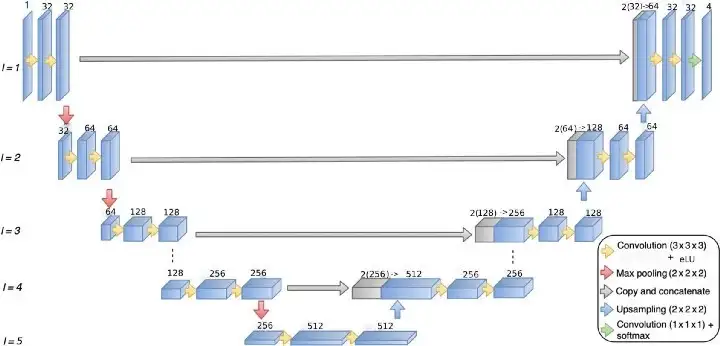

In [217]:
import keras
from keras.applications.resnet import ResNet50
from keras.applications.vgg16 import VGG16
from keras.models import Model, load_model
from keras.layers import Input, Dense, Concatenate, Activation
from keras.layers import GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D

inp = Input(shape=(256, 256, 3))

conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
conv_1_1 = Activation('relu')(conv_1_1)

conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)

pool_1 = MaxPooling2D(2)(conv_1_2)

conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)

conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)

pool_2 = MaxPooling2D(2)(conv_2_2)

conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)

conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2)

pool_3 = MaxPooling2D(2)(conv_3_2)

conv_4_1 = Conv2D(256, (3, 3), padding='same')(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)

conv_4_2 = Conv2D(256, (3, 3), padding='same')(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2)

pool_4 = MaxPooling2D(2)(conv_4_2)

up_1 = UpSampling2D(2, interpolation='bilinear')(pool_4)
conc_1 = Concatenate()([conv_4_2, up_1])

conv_up_1_1 = Conv2D(256, (3, 3), padding='same')(conc_1)
conv_up_1_1 = Activation('relu')(conv_up_1_1)

conv_up_1_2 = Conv2D(256, (3, 3), padding='same')(conv_up_1_1)
conv_up_1_2 = Activation('relu')(conv_up_1_2)

up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
conc_2 = Concatenate()([conv_3_2, up_2])

conv_up_2_1 = Conv2D(128, (3, 3), padding='same')(conc_2)
conv_up_2_1 = Activation('relu')(conv_up_2_1)

conv_up_2_2 = Conv2D(128, (3, 3), padding='same')(conv_up_2_1)
conv_up_2_2 = Activation('relu')(conv_up_2_2)

up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
conc_3 = Concatenate()([conv_2_2, up_3])

conv_up_3_1 = Conv2D(64, (3, 3), padding='same')(conc_3)
conv_up_3_1 = Activation('relu')(conv_up_3_1)

conv_up_3_2 = Conv2D(64, (3, 3), padding='same')(conv_up_3_1)
conv_up_3_2 = Activation('relu')(conv_up_3_2)

up_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)
conc_4 = Concatenate()([conv_1_2, up_4])

conv_up_4_1 = Conv2D(32, (3, 3), padding='same')(conc_4)
conv_up_4_1 = Activation('relu')(conv_up_4_1)

conv_up_4_2 = Conv2D(1, (3, 3), padding='same')(conv_up_4_1)
result = Activation('sigmoid')(conv_up_4_2)


model = Model(inputs=inp, outputs=result)

In [218]:
reconstructed_model = keras.models.load_model("my_model_v11")

При обучении модели я сохраняю веса. Для этого в каждой эпохе сохраняем лучшие и последние веса (первый и второй callbackи соответственно).

В качестве оптимизатора выберем Adam, так как он является одним из самых эффективных алгоритмов оптимизации в обучении нейронных сетей из-за его простой реализации, небольшого требования памяти и высокой вычислительной эффективности.

In [219]:
best_w = keras.callbacks.ModelCheckpoint('my_model_v11',
#                                        monitor='val_loss',
                                        verbose=0,
                                        save_best_only=True,
                                        save_weights_only=True,
                                        mode='auto')

last_w = keras.callbacks.ModelCheckpoint('my_model_v11',
#                                        monitor='val_loss',
                                        verbose=0,
                                        save_best_only=False,
                                        save_weights_only=True,
                                        mode='auto')

callbacks = [best_w, last_w]

adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(adam, 'binary_crossentropy')


Теперь обучим модель. Для этого я использую метод fit(). Его параметрами будут: keras_generator(train_df, batch_size) - входной датасет; batch_size - количество образцов; epochs=10 - количество эпох; verbose=1 значит, что мы будем выводить результат; steps_per_epoch=100 - определяем количество шагов за эпоху; для валидации создаем отдельный генератор, который будем прогонять validation_steps=100

In [220]:
batch_size = 16
reconstructed_model.fit(keras_generator(train_df, batch_size),
        batch_size=batch_size,
        epochs=1,
        verbose=1,
        shuffle=True,
        steps_per_epoch=100,
        validation_steps=100,
        validation_data=keras_generator(val_df, batch_size),
        callbacks=callbacks,
)

100/100 [==============================] - 2125s 21s/step - loss: 0.0381 - val_loss: 0.0164


После каждого обучения нейросетки будем сохранять модель, чтобы потом использовать ее для предсказаний

In [221]:
reconstructed_model.save("my_model_v11")

INFO:tensorflow:Assets written to: my_model_v11\assets


INFO:tensorflow:Assets written to: my_model_v11\assets


Посмотрим, чему научилась нейросетка:

In [222]:
pred = reconstructed_model.predict(x)

1/1 [==============================] - 3s 3s/step


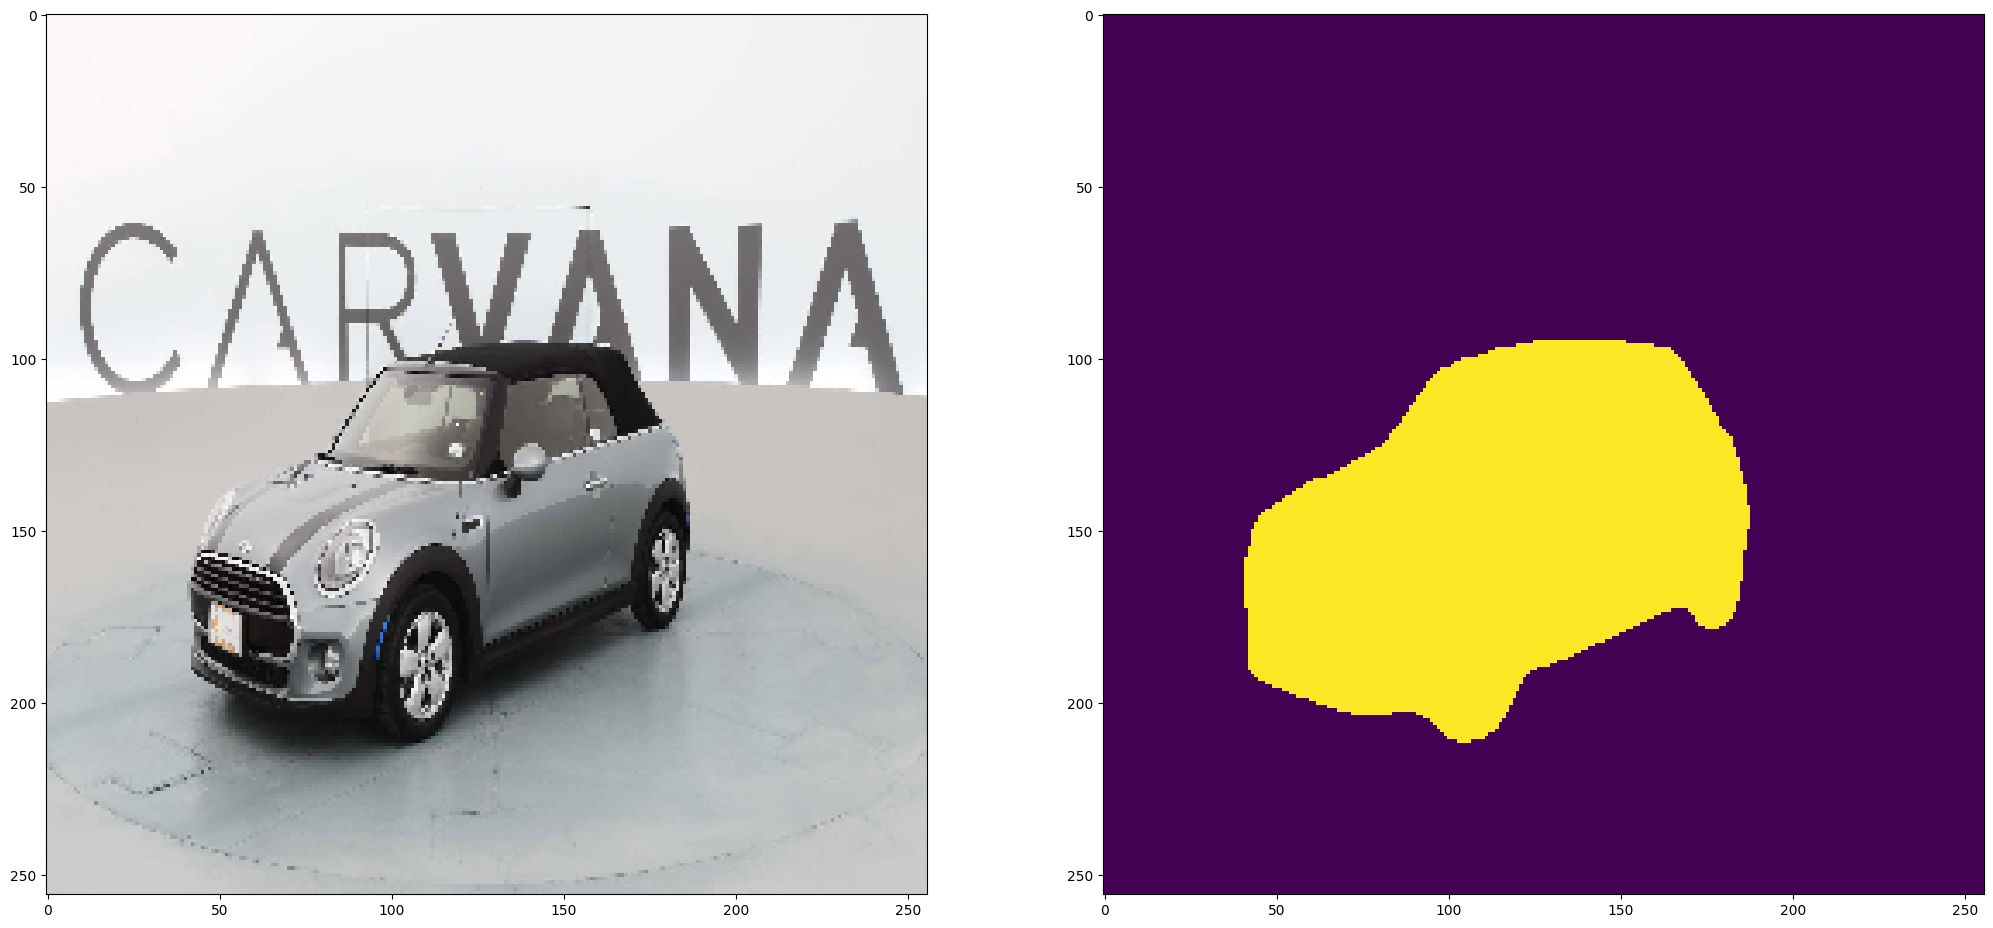

In [223]:
im_id = 9
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id, ..., 0] > 0.5)

plt.show()

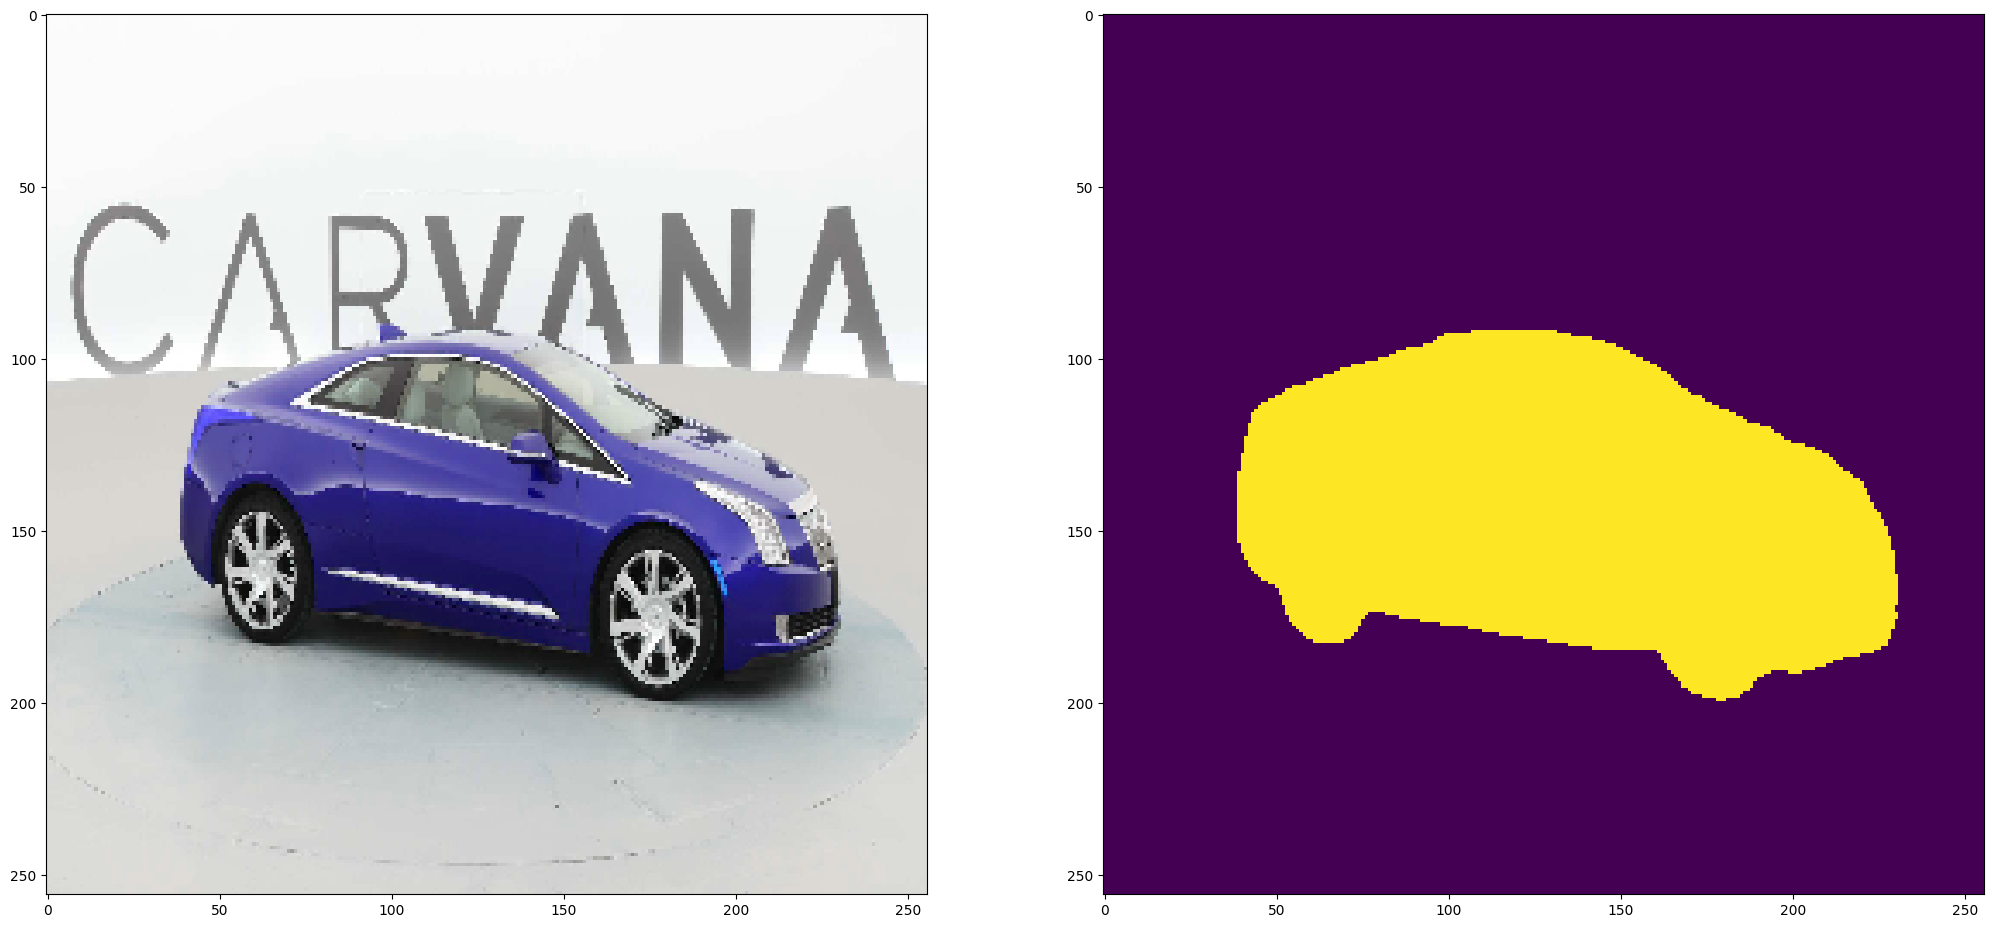

In [224]:
im_id = 4
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id, ..., 0] > 0.5)

plt.show()

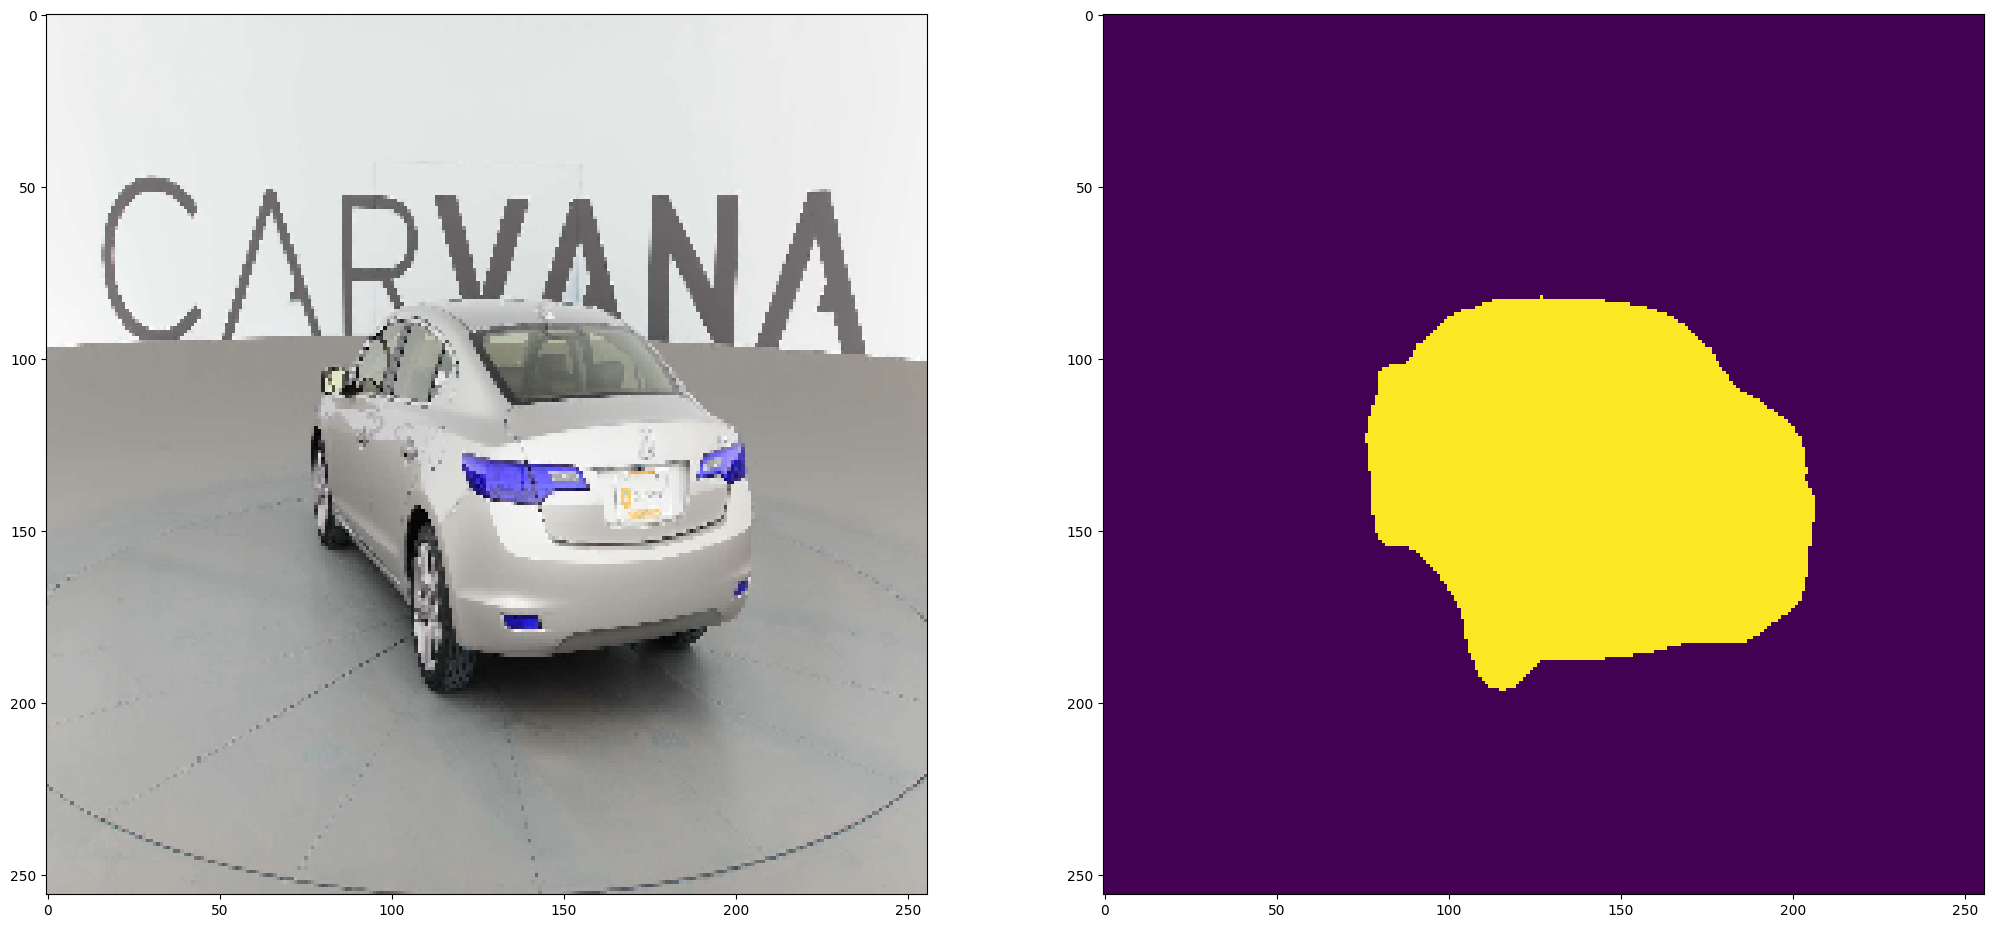

In [225]:
im_id = 1
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id, ..., 0] > 0.5)

plt.show()

1/1 [==============================] - 1s 856ms/step


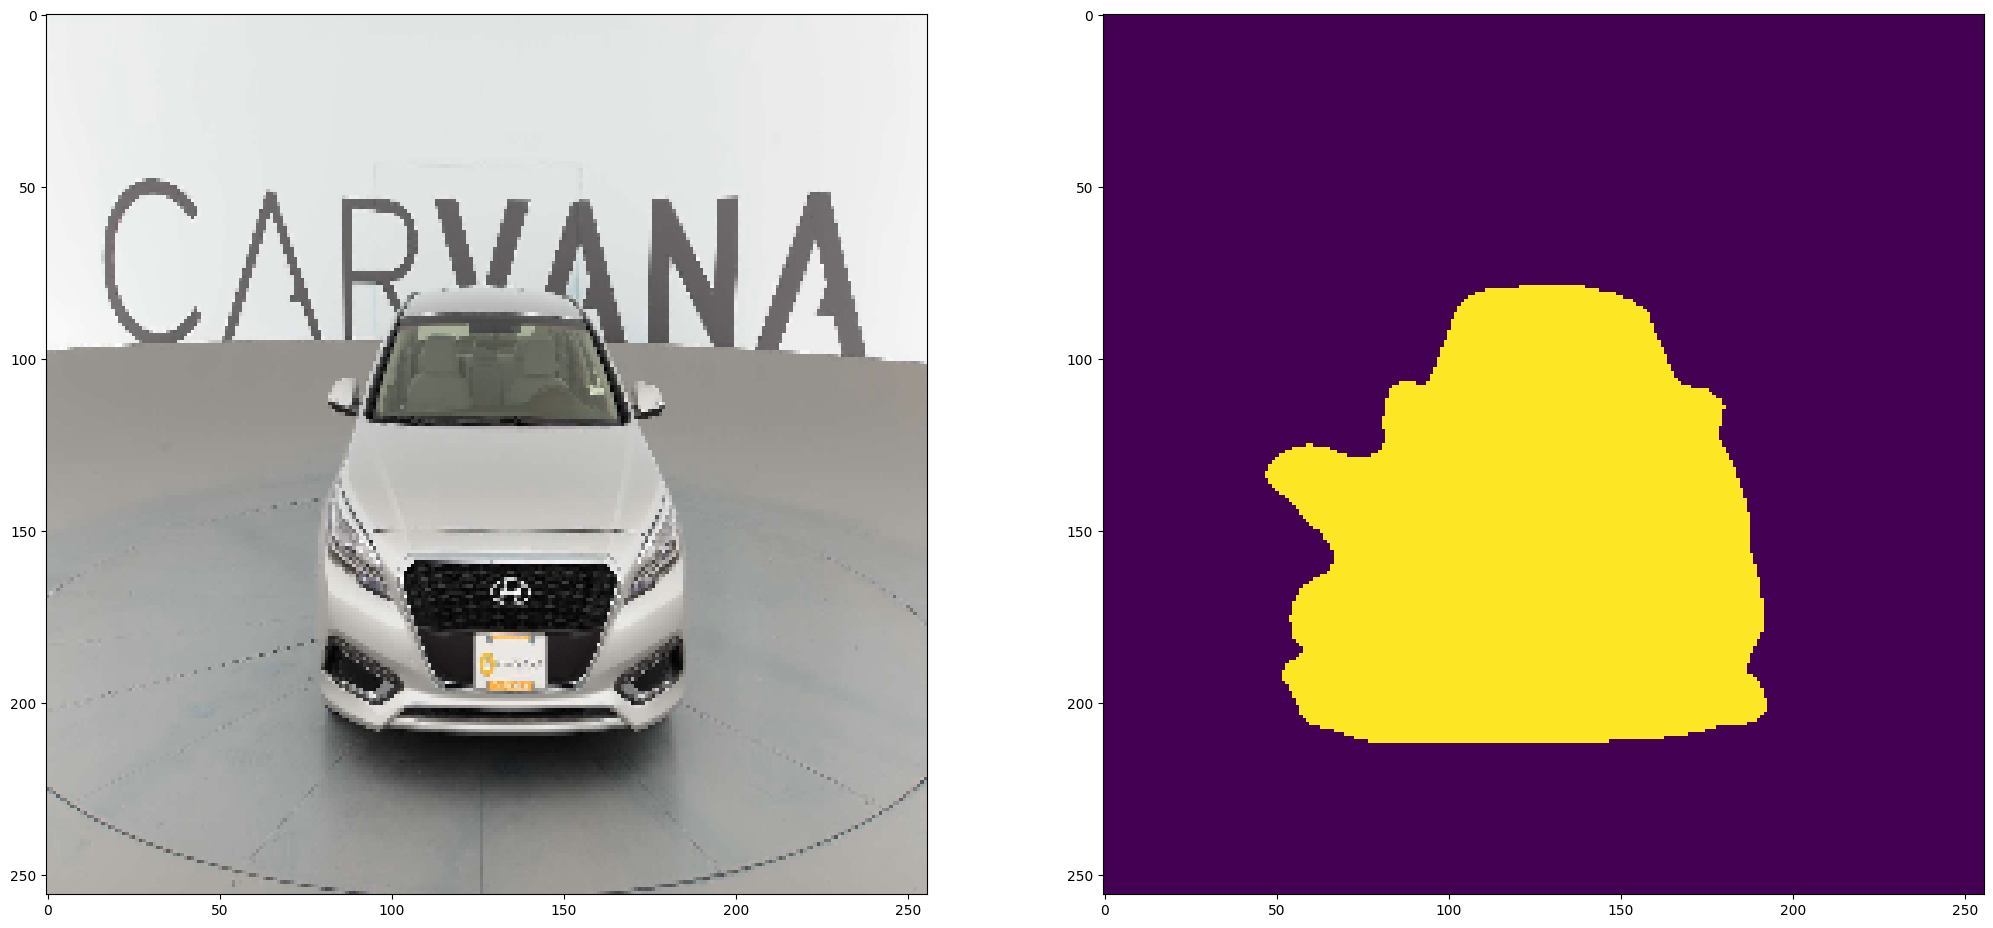

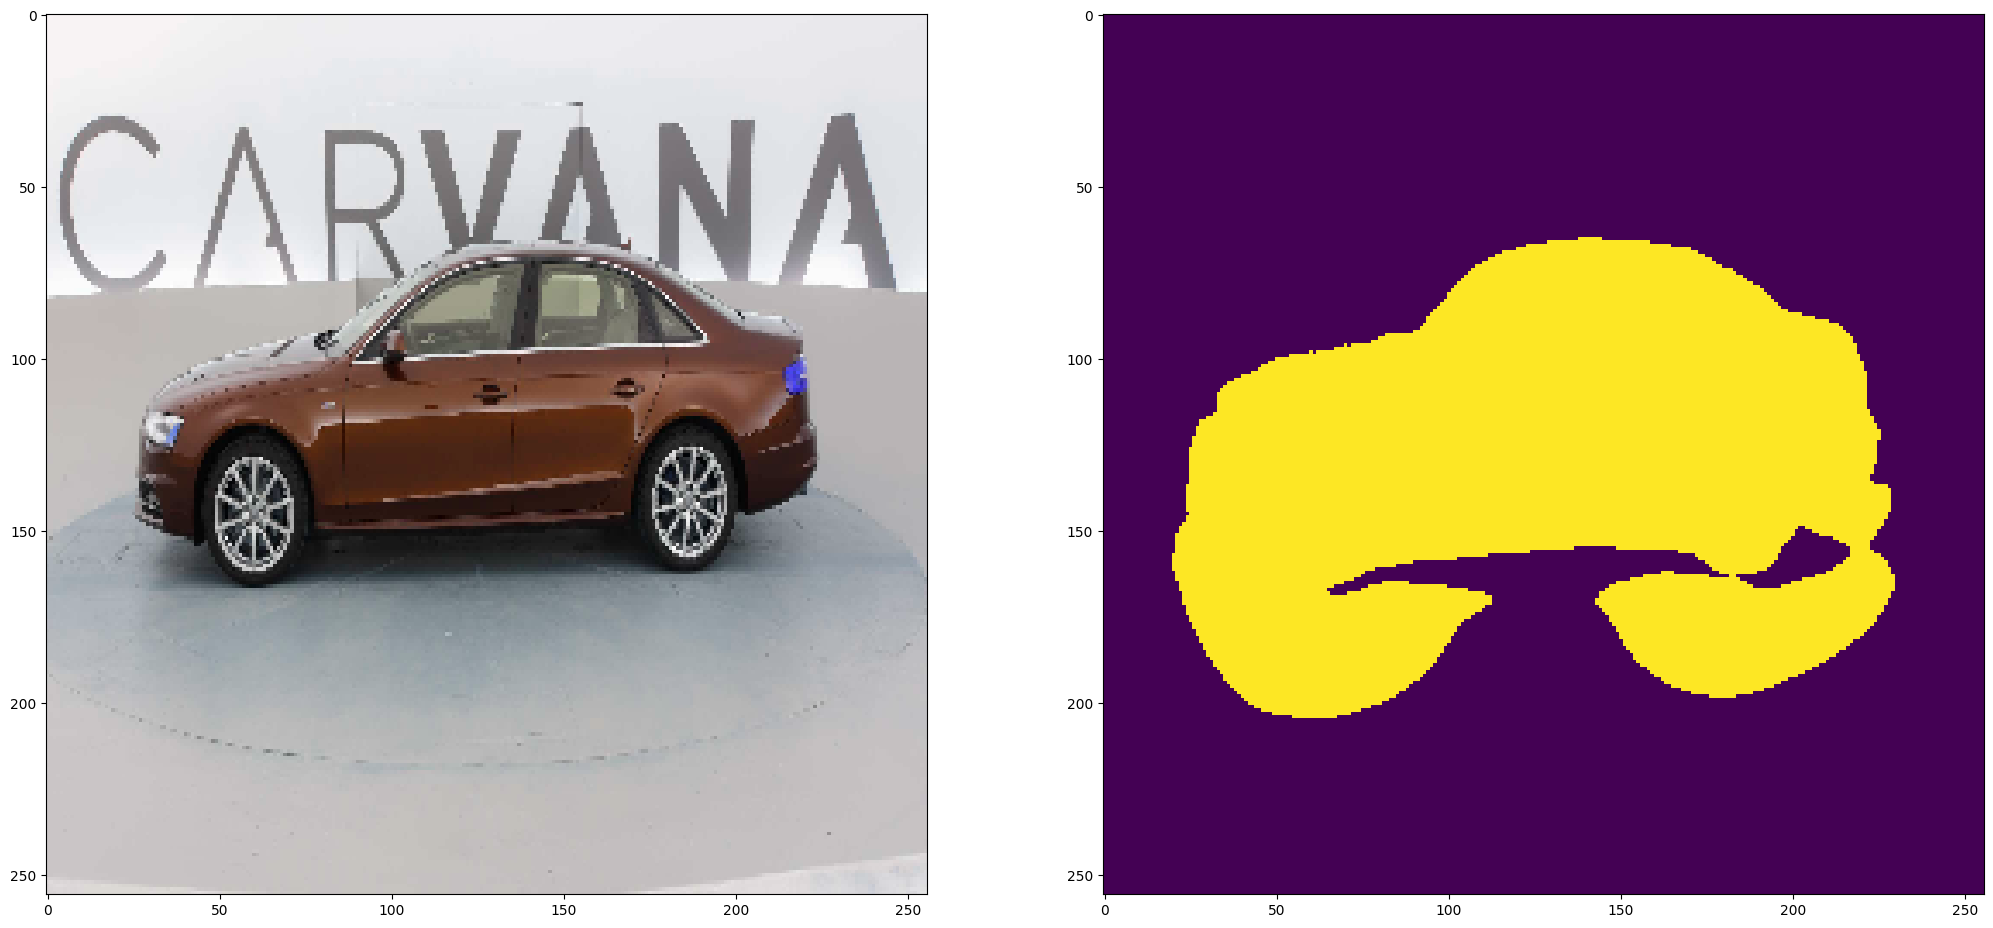

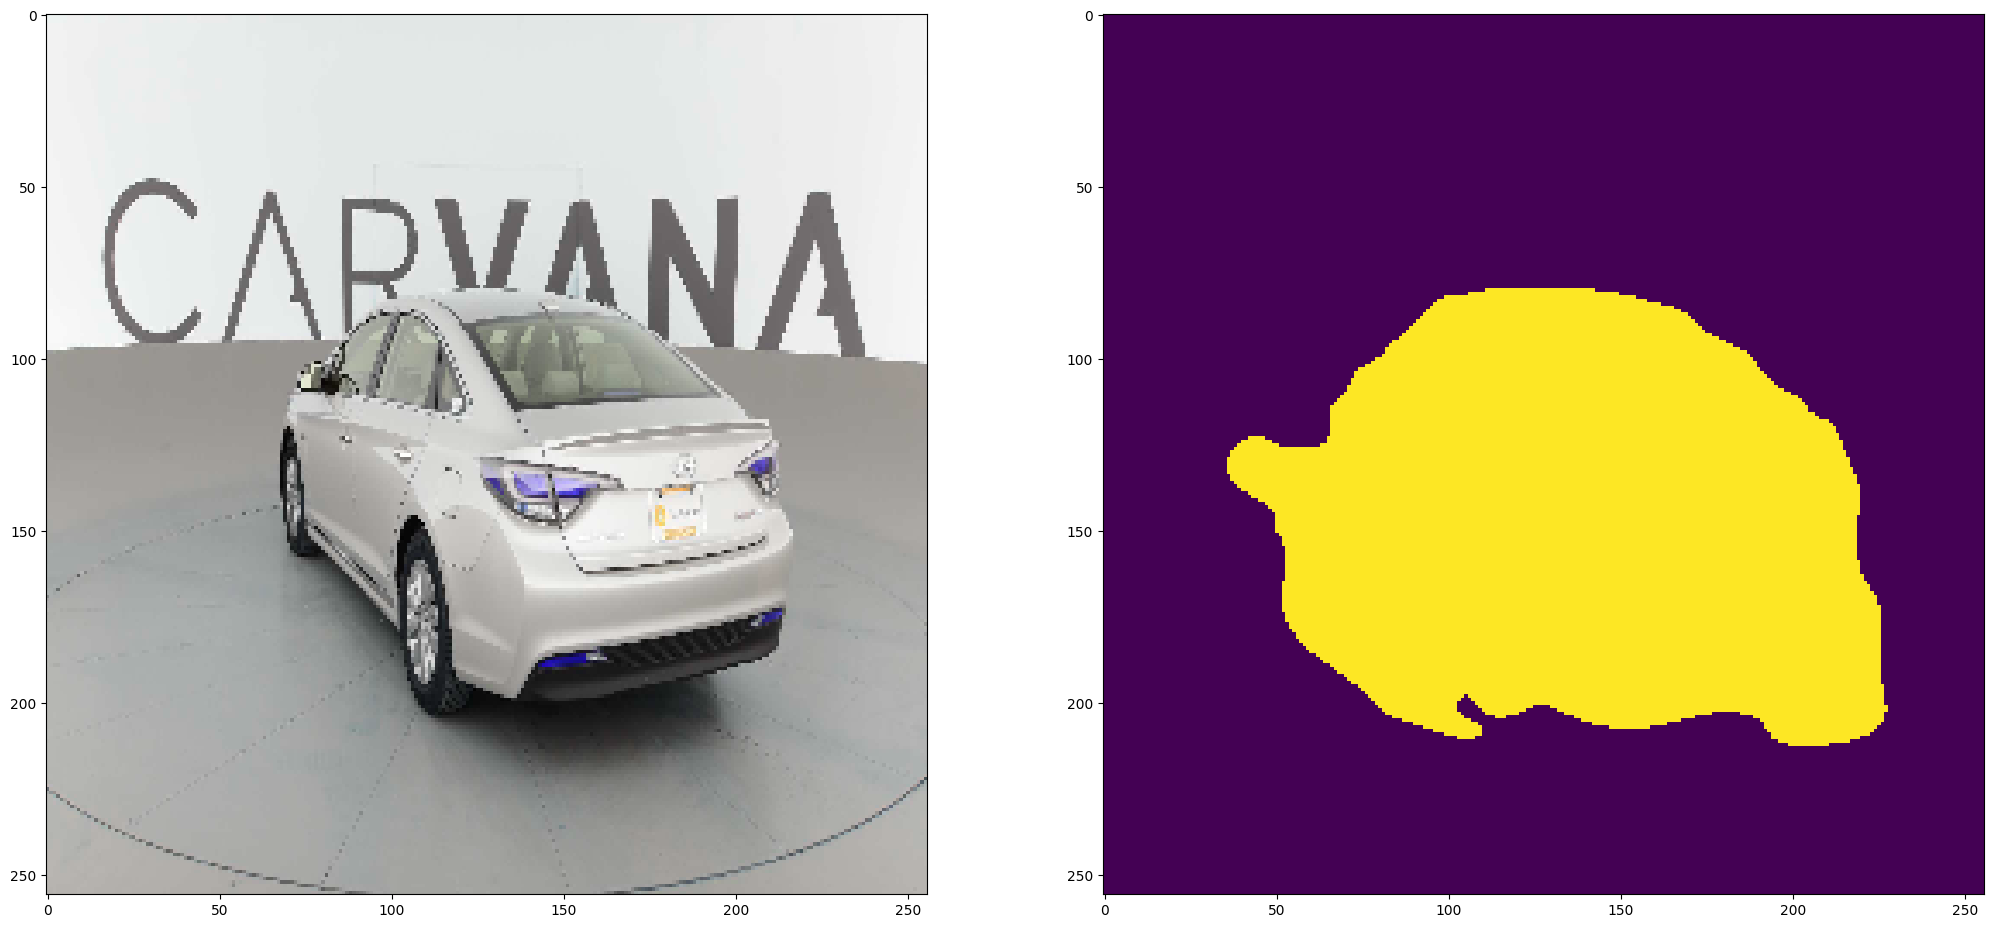

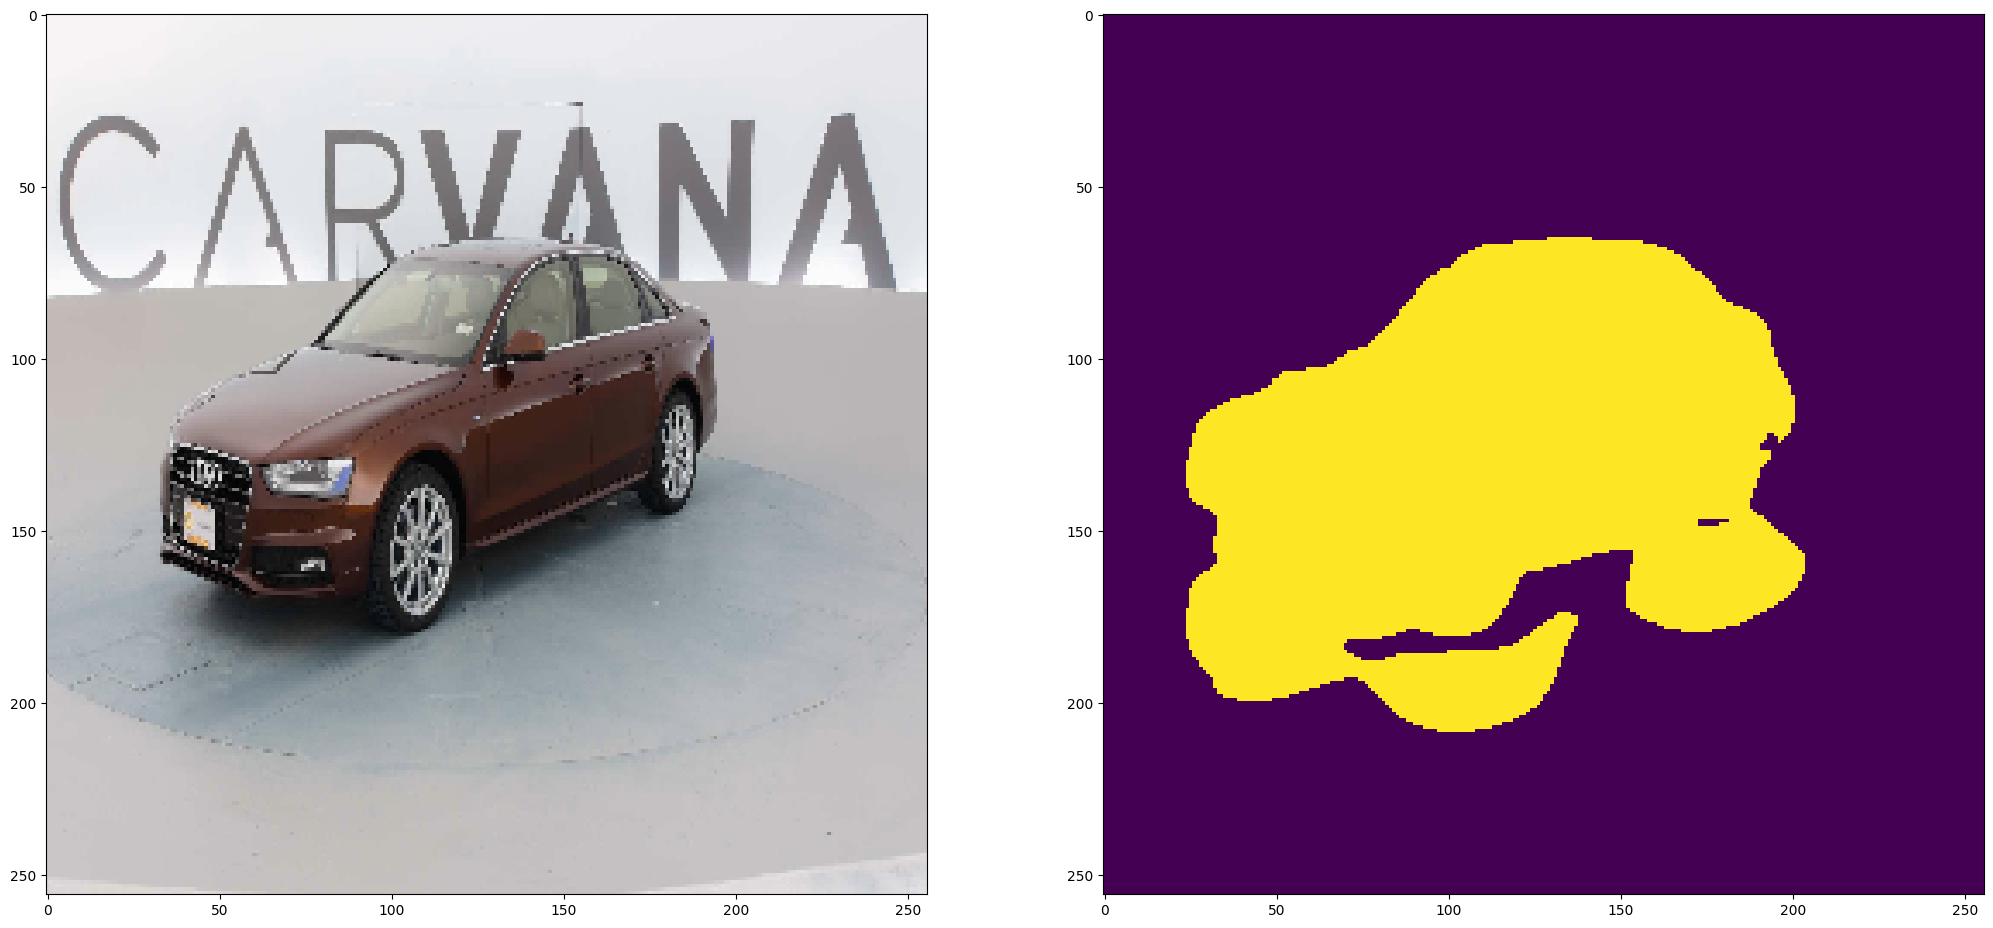

In [226]:
reconstructed_model = keras.models.load_model("my_model_v11")

image1 = cv2.imread("C:\\Users\\Aila\\OOP project\\OOP_project\\data\\test\\1.jpg")
image2 = cv2.imread("C:\\Users\\Aila\\OOP project\\OOP_project\\data\\test\\2.jpg")
image3 = cv2.imread("C:\\Users\\Aila\\OOP project\\OOP_project\\data\\test\\3.jpg")
image4 = cv2.imread("C:\\Users\\Aila\\OOP project\\OOP_project\\data\\test\\4.jpg")
  
#    (w, h) = image.shape[:-1]
    
image1 = cv2.resize(image1, (256, 256))
image2 = cv2.resize(image2, (256, 256))
image3 = cv2.resize(image3, (256, 256))
image4 = cv2.resize(image4, (256, 256))

y = np.array([image1, image2, image3, image4])
y.shape
#    matplotlib.image.imsave(input, image)
pred = reconstructed_model.predict(y)
for i in range(0, 4):
    #image_output = pred[i, ..., 0] > 0.5
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
    axes[0].imshow(y[i])
    axes[1].imshow(pred[i, ..., 0] > 0.5)
    plt.show()

In [ ]:
'''
image = cv2.imread('data/test/00087a6bd4dc_02.jpg')

image = cv2.resize(image, (256, 256))
pred = model.predict(np.array([image]))
image_output = pred[0, ..., 0] > 0.5
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(image)
axes[1].imshow(image_output)
plt.show()


image.shape

'''

"\nimage = cv2.imread('data/test/00087a6bd4dc_02.jpg')\n\nimage = cv2.resize(image, (256, 256))\npred = model.predict(np.array([image]))\nimage_output = pred[0, ..., 0] > 0.5\nfig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))\naxes[0].imshow(image)\naxes[1].imshow(image_output)\nplt.show()\n\n\nimage.shape\n\n"

In [ ]:
'''

pred = reconstructed_model.predict(np.array([image]))

#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
#axes[0].imshow(image)
#axes[1].imshow(pred[0, ..., 0] > 0.5)

#plt.show()

'''

'\n\npred = reconstructed_model.predict(np.array([image]))\n\n#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))\n#axes[0].imshow(image)\n#axes[1].imshow(pred[0, ..., 0] > 0.5)\n\n#plt.show()\n\n'

In [ ]:
'''
from keras.models import model_from_json

with open(json_file, 'r') as f:
    loaded_model = model_from_json(f.read())

loaded_model.load_weights('unet_best.h5')

loaded_res = model.predict(x)

#loaded_res == pred
'''

"\nfrom keras.models import model_from_json\n\nwith open(json_file, 'r') as f:\n    loaded_model = model_from_json(f.read())\n\nloaded_model.load_weights('unet_best.h5')\n\nloaded_res = model.predict(x)\n\n#loaded_res == pred\n"